# Doing Bayesian Data Analysis

Simple example from __Chapter 16__.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

from utils import plt, sns

In [2]:
# True params: mu = 100, sigma = 15
data = [85, 100, 115]
# Another possibility for observed data...
# y = st.norm(100, 15).rvs(5).round()
print data

with pm.Model() as model:
    # Priors
    tau = pm.Gamma("tau", .001, .001)
    mu = pm.Normal("mu", mu=0, tau=1E-8)
    # Likelihood
    y = pm.Normal("y", mu=mu, tau=tau, observed=data)
    # Sample
    trace = pm.sample(draws=6000, tune=1000, chain=3)
    
burn_in = 2000

[85, 100, 115]


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -29.175: 100%|██████████| 200000/200000 [00:11<00:00, 17012.10it/s]
Finished [100%]: Average ELBO = -29.144
100%|██████████| 6000/6000 [00:07<00:00, 839.74it/s] 


          mean         sd  mc_error    hpd_2.5    hpd_97.5
mu   99.957274  19.682902  0.394676  60.532099  134.790193
tau   0.003586   0.003423  0.000169   0.000001    0.010449


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ecefc90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f7dba10>]], dtype=object)

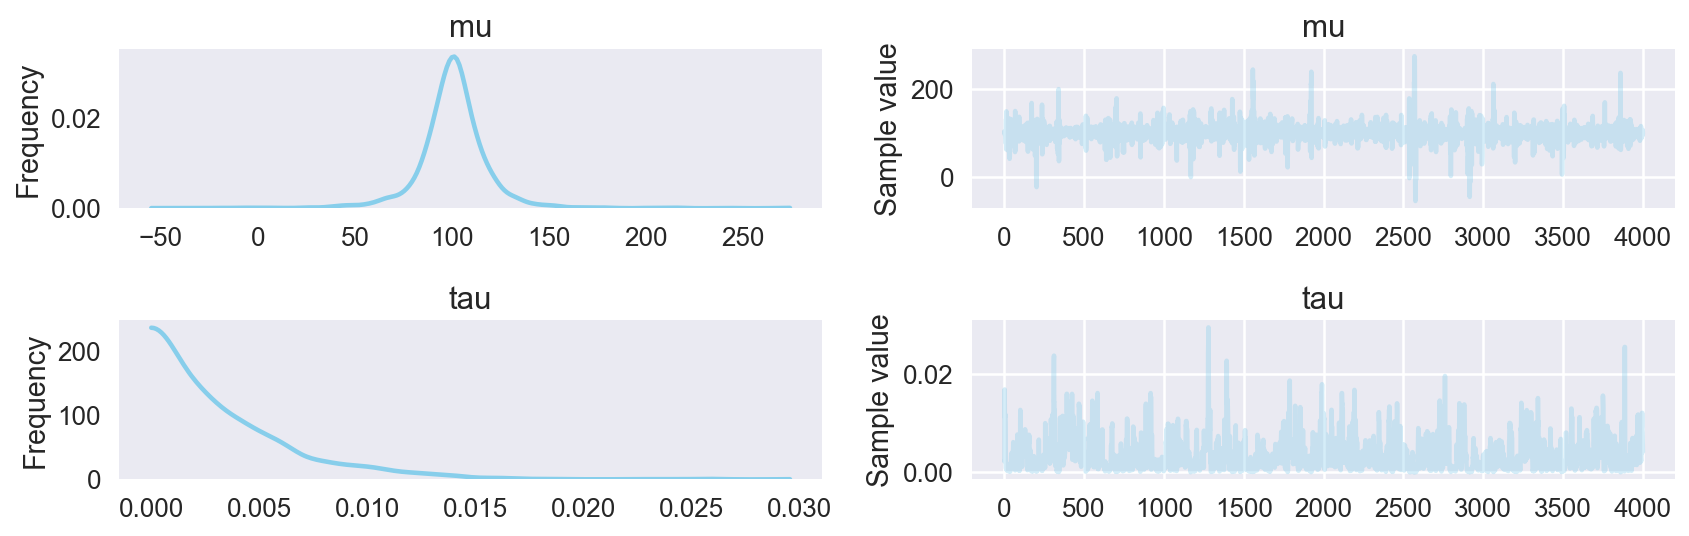

In [3]:
print pm.df_summary(trace[burn_in:])
pm.traceplot(trace[burn_in:])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ef36610>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x111058dd0>], dtype=object)

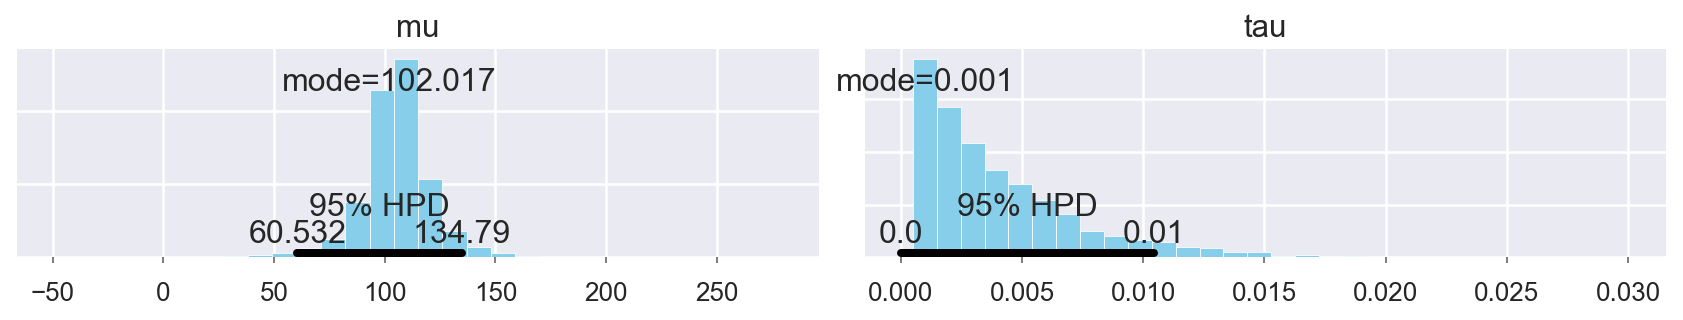

In [4]:
pm.plot_posterior(trace[burn_in:], point_estimate="mode")

### Extra Credit

It's a simple exercise, but wanted to test out two additional models:

* Use [Gelman's recommendation][gelman] of a `HalfCauchy` distribution for `sigma`
* A robust model with the `StudentT` distribution for likelihood

[gelman]: http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf

In [5]:
with pm.Model() as gelman_model:
    # Priors
    sigma = pm.HalfCauchy("sigma", 10)
    mu = pm.Normal("mu", mu=0, tau=1E-8)
    # Likelihood
    y = pm.Normal("y", mu=mu, sd=sigma, observed=data)
    # Sample
    trace = pm.sample(draws=5000, tune=1000, chain=3)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -25.723: 100%|██████████| 200000/200000 [00:11<00:00, 17140.84it/s]
Finished [100%]: Average ELBO = -25.609
100%|██████████| 5000/5000 [00:06<00:00, 795.64it/s] 


            mean         sd  mc_error    hpd_2.5    hpd_97.5
mu     99.795762  15.659254  0.342694  73.102247  130.999279
sigma  21.587460  16.093959  0.950787   6.998783   51.170331


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1126491d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112788190>]], dtype=object)

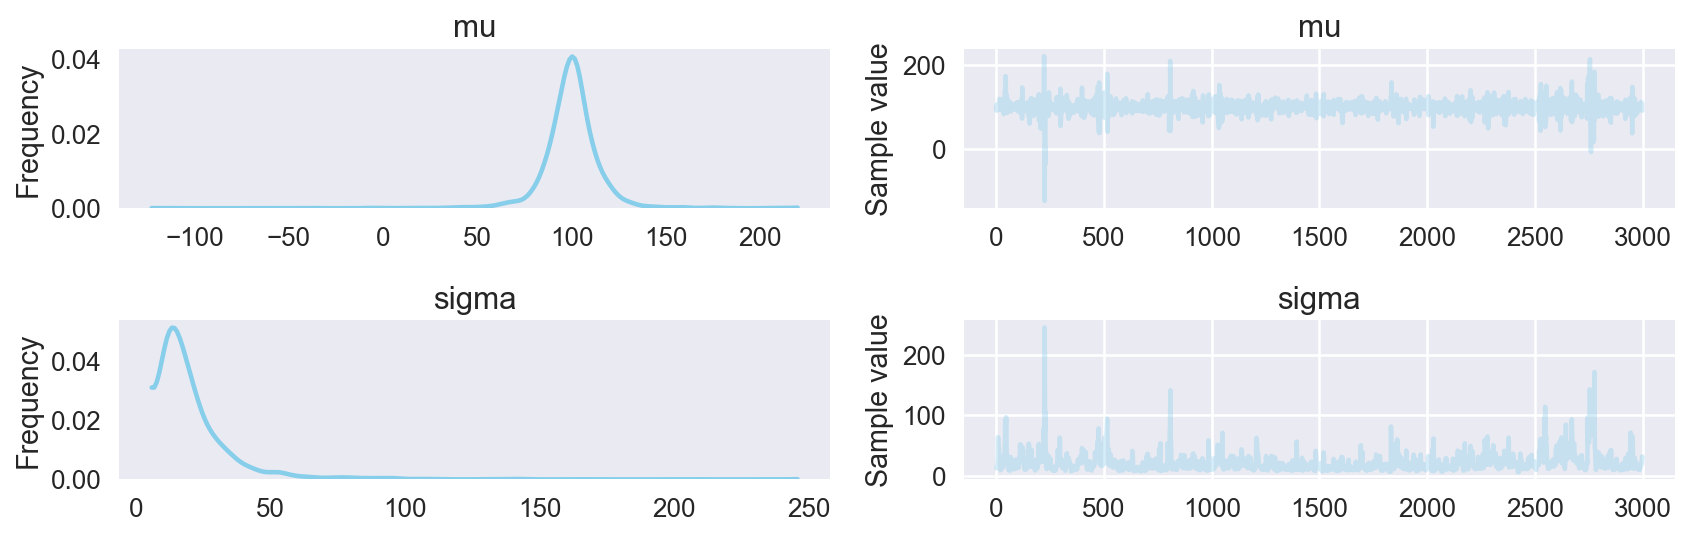

In [6]:
print pm.df_summary(trace[burn_in:])
pm.traceplot(trace[burn_in:])

In [7]:
# Mixing in a dash of robust estimation...
with pm.Model() as t_model:
    # Priors
    sigma = pm.HalfCauchy("sigma", 10)
    mu = pm.Normal("mu", mu=0, tau=1E-8)
    nu = pm.HalfCauchy("nu", 10)
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=mu, sd=sigma, observed=data)
    # Sample
    trace = pm.sample(draws=6000, tune=1000, njobs=3, chain=3)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -25.685: 100%|██████████| 200000/200000 [00:17<00:00, 11720.30it/s]
Finished [100%]: Average ELBO = -25.62
100%|██████████| 6000/6000 [00:33<00:00, 178.68it/s]


             mean          sd  mc_error    hpd_2.5    hpd_97.5
mu     100.002529   14.326211  0.187933  74.769144  124.783395
sigma   18.321624   15.644643  0.362955   4.227314   40.758194
nu      41.556024  223.969662  4.053609   0.223880  115.205881


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fa5f9d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111a2ccd0>]], dtype=object)

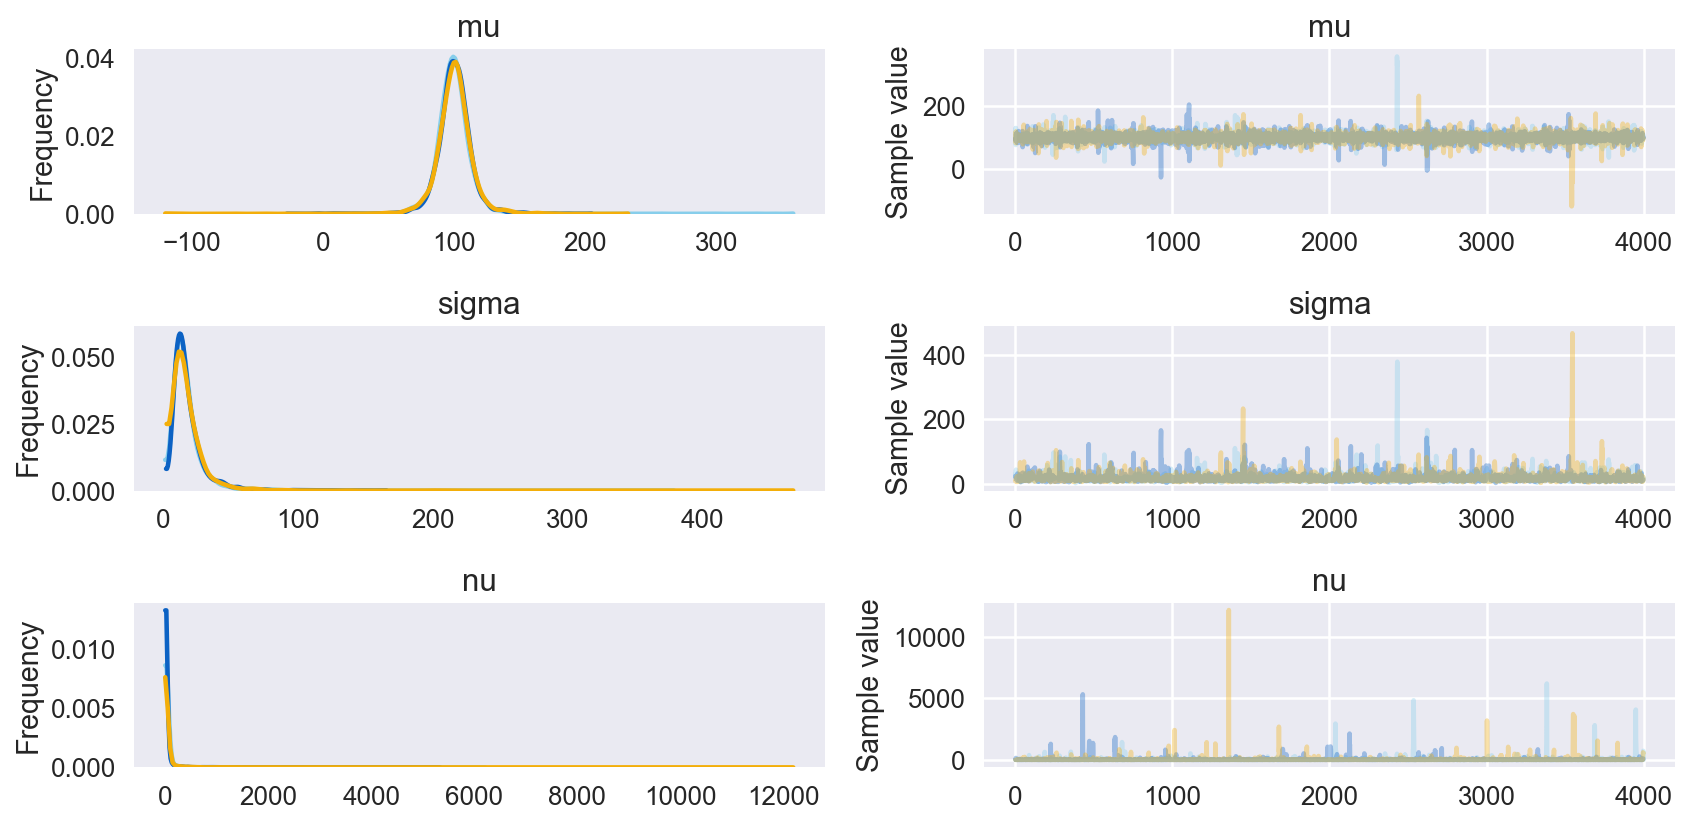

In [8]:
print pm.df_summary(trace[burn_in:])
pm.traceplot(trace[burn_in:])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10f054b10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x110060f10>], dtype=object)

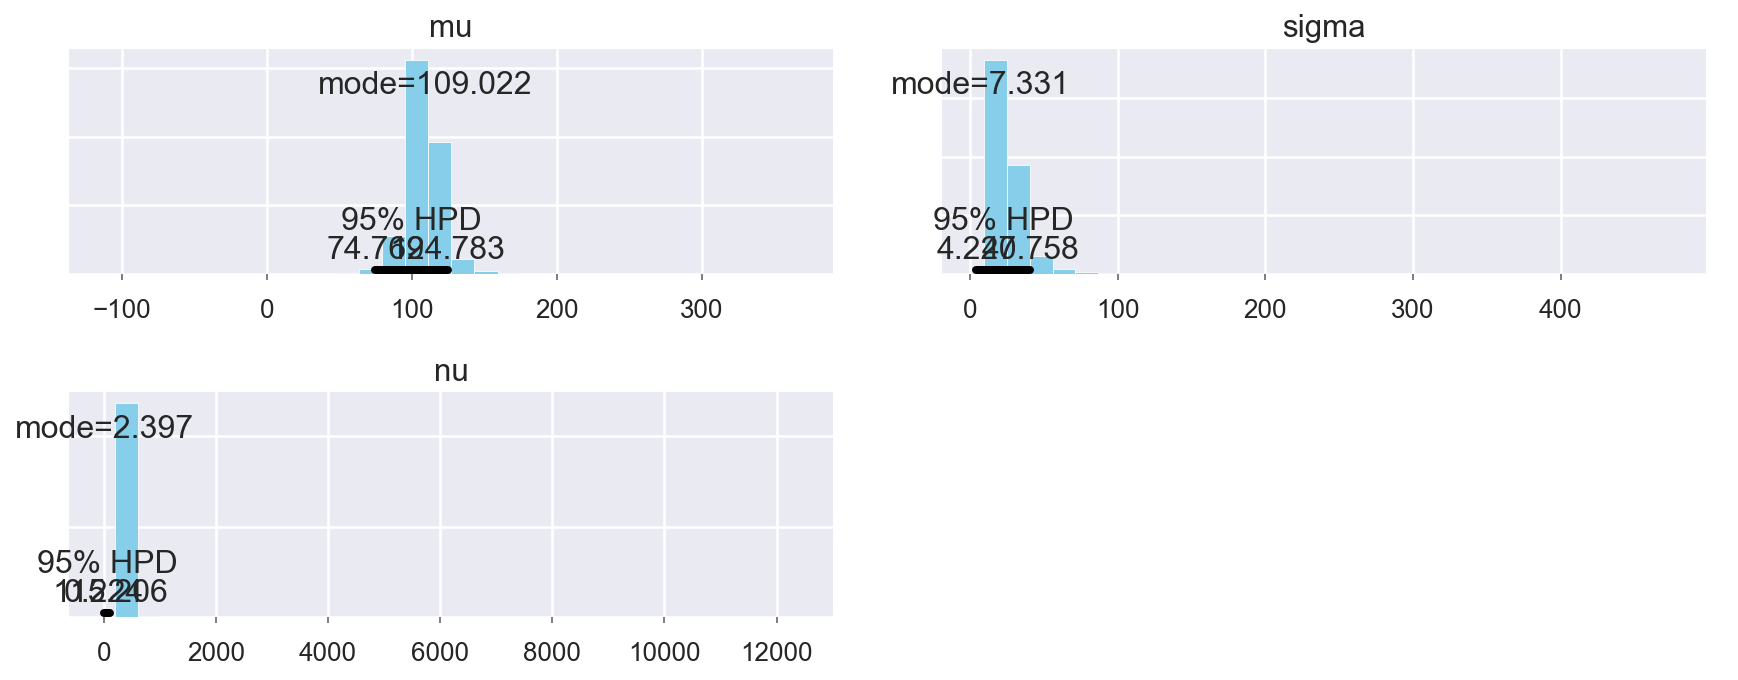

In [9]:
pm.plot_posterior(trace[burn_in:], point_estimate="mode")

In [10]:
# Wanted to take a closer look at `nu`
pm.summary(trace[burn_in:], varnames=["nu"])


nu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  41.556           223.970          4.054            [0.224, 115.206]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.032          4.893          10.427         23.740         235.466



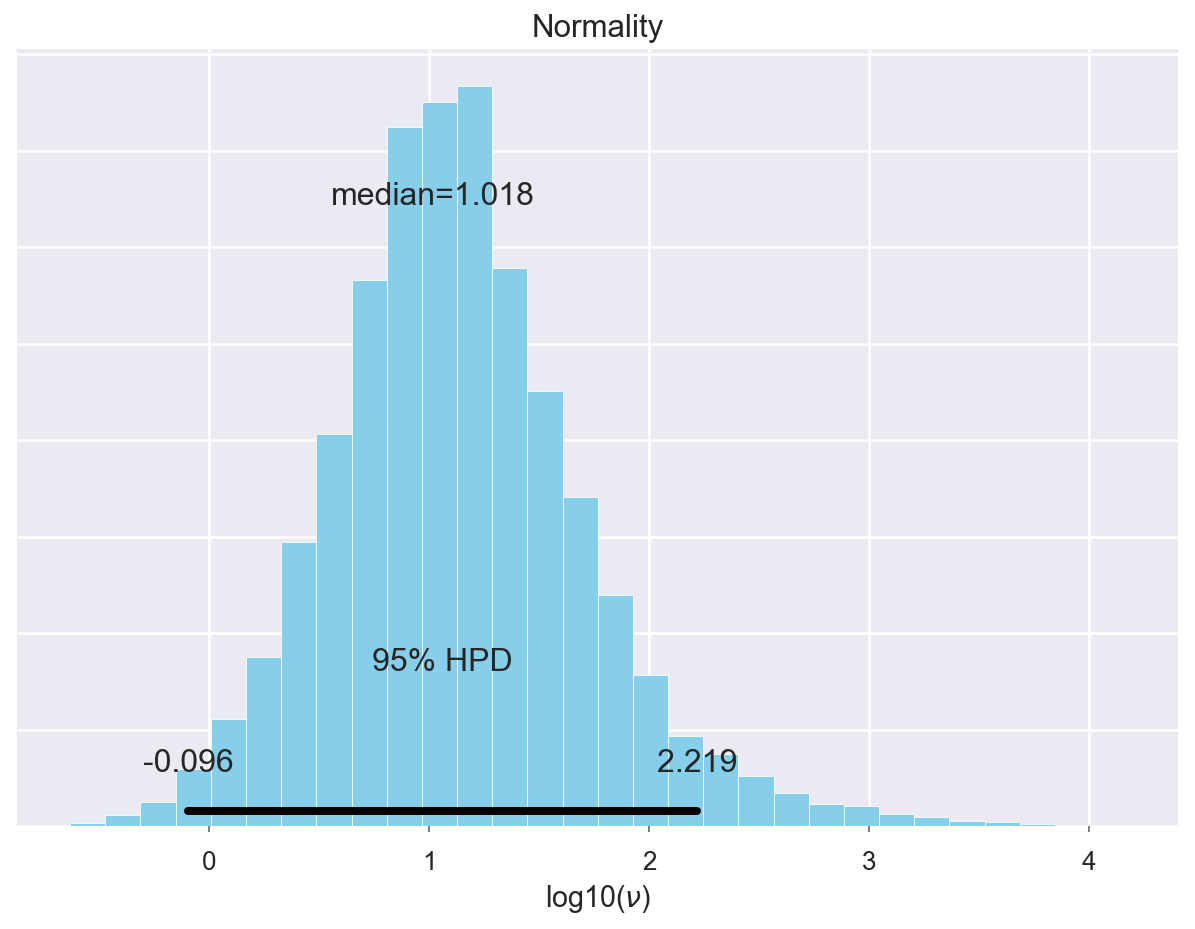

In [11]:
normality = np.log10(trace[burn_in:]["nu"])
ax = pm.plot_posterior(normality, point_estimate="median")
ax.set_title("Normality")
ax.set_xlabel(r"log10($\nu$)")

In [12]:
# PyMC's Gelman-Rubin check (Rhat)
pm.diagnostics.gelman_rubin(trace[burn_in:])

{'mu': 0.99997296427710813,
 'nu': 1.0001188871551587,
 'nu_log_': 0.99997204767245118,
 'sigma': 1.0001450707361588,
 'sigma_log_': 1.0003350698630593}